In [46]:
import warnings
warnings.filterwarnings("ignore")

from src.acquire import get_zillow_data
from src.prepare import wrangle_zillow, geo_df, split_data

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

charizard = ['#FCC499', '#F2684A', '#FAAA6D', '#419EAE', '#FFEEB0']
sns.set_palette(sns.color_palette(charizard))

import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

import eli5


In [2]:
"""
df = get_zillow_data()
df = wrangle_zillow(df)
df.to_csv("data/sfr_2017.csv")
"""
df = pd.read_csv("data/sfr_2017.csv", index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26600 entries, 0 to 28123
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   transactiondate  26600 non-null  object 
 1   latitude         26600 non-null  float64
 2   longitude        26600 non-null  float64
 3   bedroomcnt       26600 non-null  int64  
 4   bathroomcnt      26600 non-null  int64  
 5   sqft             26600 non-null  int64  
 6   taxvalue         26600 non-null  int64  
 7   year             26600 non-null  int64  
 8   taxamount        26600 non-null  int64  
 9   taxrate          26600 non-null  float64
 10  fips             26600 non-null  int64  
 11  logerror         26600 non-null  float64
 12  county           26600 non-null  object 
dtypes: float64(4), int64(7), object(2)
memory usage: 2.8+ MB


In [3]:
df.head()

,transactiondate,latitude,longitude,bedroomcnt,bathroomcnt,sqft,taxvalue,year,taxamount,taxrate,fips,logerror,county
0,2017-07-21,34.033180,-118.355396,3,2,1316,205123,1923,2627,0.012809,6037,0.017785,Los Angeles
1,2017-06-23,34.686163,-118.113100,3,2,1458,136104,1970,2319,0.017045,6037,-0.362001,Los Angeles
2,2017-06-30,33.999877,-118.291863,2,1,1421,35606,1911,543,0.015270,6037,-0.146056,Los Angeles
3,2017-06-01,33.694636,-117.912245,4,3,2541,880456,2003,9819,0.011153,6059,0.021085,Orange
4,2017-08-23,33.873860,-118.338253,3,2,1491,107110,1955,1399,0.013064,6037,-0.163064,Los Angeles


In [4]:
y = df.pop('taxvalue')
X_train, X_test, X_val, y_train, y_test, y_val = split_data(df, y, .15)

X_train, X_test, X_val, y_train, y_test, y_val
(18619, 12) (3990, 12) (3991, 12) (18619,) (3990,) (3991,)


In [5]:
X_train.county.value_counts()

Los Angeles    11821
Orange          5117
Ventura         1681
Name: county, dtype: int64

In [6]:
#https://gisdata-scag.opendata.arcgis.com/datasets/county-boundaries-scag-region/explore?filters=eyJBQ1JFUyI6WzY4Ny40OTYwMjEyOCwyNzUwNTIyLjMyXX0%3D&location=34.131659%2C-116.867850%2C7.00
file = 'data/County_Boundaries/County_Boundaries_%E2%80%93_SCAG_Region.shp'
geo_df, map_ = geo_df(X_train, file)

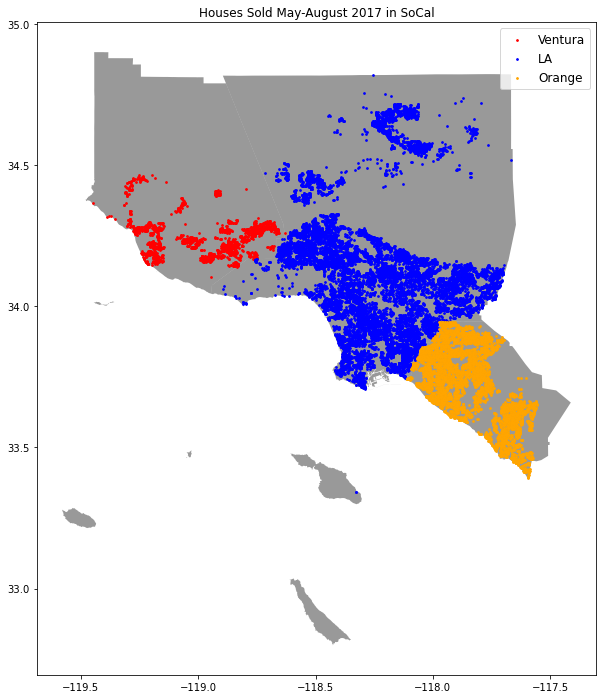

In [11]:
f, ax = plt.subplots(figsize=(15,12))
map_.plot(ax=ax, alpha=.4, color='black')
geo_df[geo_df.fips==6111].plot(ax=ax, markersize=3, color='red', label="Ventura")
geo_df[geo_df.fips==6037].plot(ax=ax, markersize=3, color='blue', label="LA")
geo_df[geo_df.fips==6059].plot(ax=ax, markersize=3, color='orange', label="Orange")
plt.title("Houses Sold May-August 2017 in SoCal")
plt.legend(prop={'size':12});

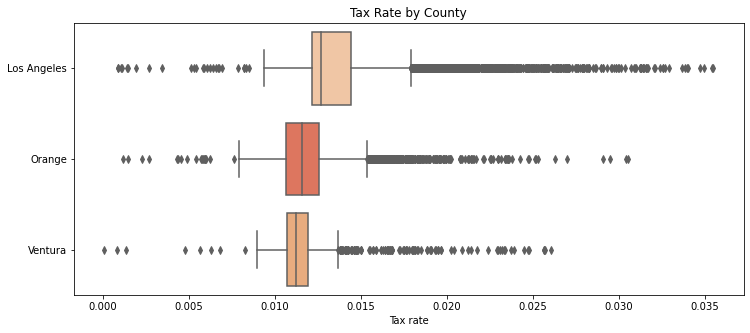

In [8]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=X_train, y='county', x='taxrate')
plt.ylabel("")
plt.xlabel("Tax rate")
plt.title("Tax Rate by County")
plt.show()

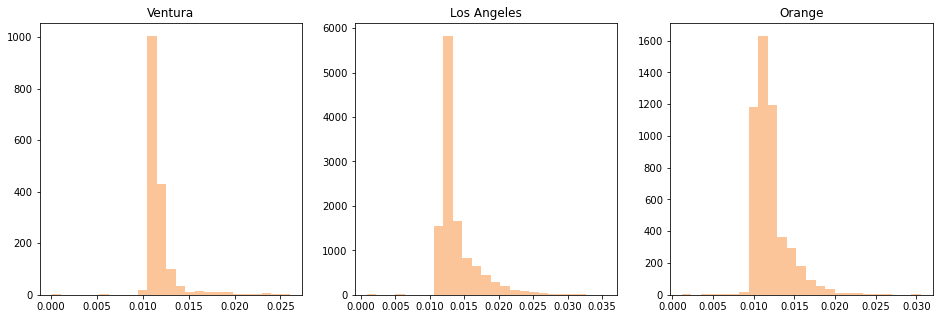

In [10]:
counties = ["Ventura", "Los Angeles", "Orange"]
plt.figure(figsize=(16, 5))
for i, county in enumerate(counties):
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 
    plt.subplot(1, len(counties), plot_number)
    plt.title(county)
    X_train.taxrate[X_train.county==county].hist(bins=25)
    plt.grid(False)

## Models

In [53]:
y_pred = np.zeros((len(y_val),))
y_pred += y_train.mean()

In [54]:
print(mean_squared_error(y_val, y_pred))
print(r2_score(y_val, y_pred))

101639115748.36024
-0.0001597782264071146


In [56]:
xvars = ['sqft','bedroomcnt','bathroomcnt']

reg = LinearRegression().fit(X_train[xvars], y_train)
y_pred = reg.predict(X_val[xvars])

In [57]:
print(mean_squared_error(y_val, y_pred))
print(r2_score(y_val, y_pred))

70308323321.64058
0.308144737947732
